### Semantic features as word embeddings

In [1]:
import numpy as np
import os
import torch
import json
from tqdm import tqdm

### Semantic features

In [2]:
min_len_line = 5
N_SEMANTIC_FEATURES = 25
semantic_features = {}

def dump_mitchell_web_semantic_features(raw_file = os.path.join("data","mitchell_semantic_raw.txt")):
    with open(raw_file, "r") as datafile:
        lines = datafile.readlines()
        word = None

        for line in lines:

            # Skip empty
            if len(line) >= min_len_line:

                # New feature
                if "Features for" in line:

                    # Discard invalid ones (once fully parsed)
                    if word and len(semantic_features[word]['features']) < N_SEMANTIC_FEATURES: del semantic_features[word] 
                        
                    word = line.split("<a name=\"")[1].split("\"")[0]
                    semantic_features[word] = { "features": [], "values": []}

                elif word:
                    feature_name = line.split("(")[0]
                    val = float(line.split("(")[1].split(")")[0])
                    semantic_features[word]["features"].append(feature_name)
                    semantic_features[word]["values"].append(val)

    # Save to file
    with open(os.path.join('data', 'mitchell_semantic_features.json'), 'w') as fp:
        json.dump(semantic_features, fp)

    return semantic_features

In [3]:
semantic_features = dump_mitchell_web_semantic_features()

### fMRI data

In [4]:
def get_word_activations(path, skip_lines=0):
    """
        Returns dataset of fMRI word activations
        path            Path to .txt fMRI data vectors (continuous) from Cognival
        context_len     Words before the occurring one
        data            Returned dictionary with key ['word'] -> {'context', 'activations'}
    """
    data = {}
    with open(path, "r") as datafile:
        lines = datafile.readlines()[skip_lines:] # skip header
        for line in tqdm(lines):
            word = line.split(" ")[0]
            activations = np.array([float(x) for x in line.split(" ")[1:]])
            data[word] = {"activations": activations}
    return data

In [5]:
subject = 1
voxels = 1000

# Over all subjects
filename = os.path.join("data", "cognival", "fmri", "nouns", f"{voxels}-random-voxels", f"scaled_{voxels}_mitchell_targets_{subject}.txt")
fmriData = get_word_activations(filename, skip_lines = 1)

100%|██████████| 60/60 [00:00<00:00, 2227.48it/s]


### Predicting

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm

In [7]:
# Building train set
X = []
Y = []
for word in tqdm(semantic_features.keys()):
    if word in fmriData.keys():
        X.append(semantic_features[word]["values"])
        Y.append(fmriData[word]["activations"])

# Fetch fMRI activations from the dataset
X = np.array(X)
Y = np.array(Y)

100%|██████████| 59/59 [00:00<?, ?it/s]


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.03, random_state=42)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(57, 25) (2, 25)
(57, 1000) (2, 1000)


In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

# make_pipeline(StandardScaler(with_mean=False), LinearRegression())
predictors = [LinearRegression() for i in range(voxels)]
scores = []

# One predictor per voxel
i = 0
for model in tqdm(predictors):
    model.fit(X_train, y_train[:, i])
    scores.append(model.score(X_test, y_test[:, i]))
    i += 1

scores = np.array(scores)

100%|██████████| 1000/1000 [00:00<00:00, 1476.89it/s]


In [17]:
# Picking the best 100 predictors (voxels)
K = 100
ind = np.argpartition(scores, -K)[-K:]

print("min \t\t max \t\t mean")
print(f"{np.min(scores[ind]):.4f} \t\t {np.max(scores[ind]):.4f} \t {np.mean(scores[ind]):.4f}")

min 		 max 		 mean
0.3134 		 0.9952 	 0.6793


Test RDMs R^2:	PearsonRResult(statistic=0.06353489710146562, pvalue=0.00029035443943860626)


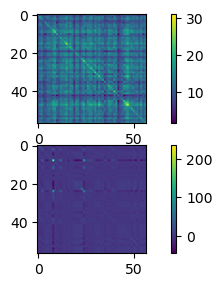

In [24]:
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

def best_K_predict(X, indices, predictors):
    predictors = [predictors[idx] for idx in indices]
    y_hat = np.array([predictor.predict(X) for predictor in predictors]) # voxels, sample
    return y_hat.reshape(y_hat.shape[1], y_hat.shape[0]) # sample, voxels


y_hat = best_K_predict(X_train, ind, predictors)
y = y_train[:, ind]

RDM_hat = np.matmul(y_hat, np.matrix.transpose(y_hat))
# RDM_hat = (RDM_hat - RDM_hat.min()) / (RDM_hat.max() - RDM_hat.min())

RDM = np.matmul(y, np.matrix.transpose(y))
# RDM = (RDM - RDM.min()) / (RDM.max() - RDM.min())

test_pearson = pearsonr(
    RDM_hat.flatten(),
    RDM.flatten()
)

print(f"Test RDMs R^2:\t{test_pearson}")

plt.subplot(311)
plt.imshow(RDM)
plt.colorbar()

plt.subplot(312)
plt.imshow(RDM_hat)
plt.colorbar()